In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.sweep_plotting as splot
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np
import qutip as qt

# Working with composite Hilbert spaces and interfacing with QuTiP

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}g^{(\alpha)} n_\alpha(a+a^\dagger)$

### Define Hilbert space components, initialize HilbertSpace object

In [2]:
# Set up the components / subspaces of our Hilbert space

CPB1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.Transmon(
    EJ = 30.0,
    EC = 0.15,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    E_osc = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([CPB1, CPB2, resonator])

In [3]:
print(hilbertspace)

====== HilbertSpace object ======

TRANSMON
 ———— PARAMETERS ————
EJ	: 40.0
EC	: 0.2
ng	: 0.3
ncut	: 40
truncated_dim	: 3
Hilbert space dimension	: 81

TRANSMON
 ———— PARAMETERS ————
EJ	: 30.0
EC	: 0.15
ng	: 0.0
ncut	: 10
truncated_dim	: 4
Hilbert space dimension	: 21

OSCILLATOR
 ———— PARAMETERS ————
truncated_dim	: 4
E_osc	: 6.0
Hilbert space dimension	: 4



Obtain the bare Hamiltonian of the non-interacting subsystems:

In [4]:
bare_hamiltonian = hilbertspace.bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-63.0886372    0.           0.         ...   0.           0.
    0.        ]
 [  0.         -57.0886372    0.         ...   0.           0.
    0.        ]
 [  0.           0.         -51.0886372  ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -24.66024074   0.
    0.        ]
 [  0.           0.           0.         ...   0.         -18.66024074
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  -12.66024074]]

### Set up interaction terms between individual subsystems

In [5]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    op1 = CPB1.n_operator(),
    subsys1 = CPB1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    op1 = CPB2.n_operator(),
    subsys1 = CPB2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Now insert the interaction terms into the HilbertSpace object.

In [6]:
interaction_list = [interaction1, interaction2]

hilbertspace.interaction_list = interaction_list

Now that the interactions are specified, the full Hamiltonian of the coupled system can be obtained via:

In [7]:
dressed_hamiltonian = hilbertspace.hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-6.30886372e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -5.70886372e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -5.10886372e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.46602407e+01
   4.24264069e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264069e-02
  -1.86602407e+01  5.19615242e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615242e-02 -1.26602407e+01]]

Since the composite Hamiltonian is a `qubit.Qobj`, The eigenvalues and eigenvectors can be now be obtained via the usual QuTiP routine:

In [8]:
evals, evecs = dressed_hamiltonian.eigenstates(eigvals=4)
print(evals)

[-63.09882162 -57.51117008 -56.87227527 -55.29218444]


### Spectrum lookup and converting between bare and dressed indices

To use lookup functions for state indices, energies and states, first generate the lookup table via:

In [9]:
hilbertspace.generate_lookup()

Here are the bare energies of the first Cooper pair box system:

In [10]:
hilbertspace.lookup.bare_eigenenergies(CPB1)

array([-36.05064983, -28.25601136, -20.67410141])

The dressed state with index j=3 corresponds to following bare product state:

In [11]:
hilbertspace.lookup.bare_index(8)

(1, 0, 1)

And the bare product state (1,2,1) most closely matches the following dressed state:

In [12]:
hilbertspace.lookup.dressed_index((1,2,1))

21

In [13]:
hilbertspace.lookup.bare_eigenstates(CPB1);

# Sweeping over an external parameter

scqubits provides the class `ParameterSweep` to facilitate computation of spectra as function of an external parameter. For efficient usage in the `Explorer` class, computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Consider the case where both `CPB1` and `CPB2` subsystems are flux-tunable split-junction transmons with different loop areas. 

In [16]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(0., 2.0, 300)     # parameter values

subsys_update_list = [CPB1, CPB2]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    CPB1.EJ = 20*np.abs(np.cos(np.pi * param_val))
    CPB2.EJ = 15*np.abs(np.cos(np.pi * param_val * 0.65))

    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=20,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace
)


In [15]:
sweep.lookup.bare_eigenstates(CPB1, 21)

array([[-4.36541328e-50, -2.75880308e-54,  8.97850818e-52],
       [-3.11868192e-49, -2.79006815e-54, -8.74802339e-53],
       [-8.58246250e-50, -1.00876179e-53, -1.01005272e-51],
       [ 1.07036276e-49, -7.49520810e-52,  3.40138146e-51],
       [ 2.22076735e-50, -9.29825414e-50,  5.29476367e-49],
       [ 9.31798507e-49, -1.09455894e-47,  6.20160456e-47],
       [ 1.48748935e-46, -1.21908616e-45,  6.87331138e-45],
       [ 1.57335293e-44, -1.28270423e-43,  7.19436330e-43],
       [ 1.57038899e-42, -1.27291721e-41,  7.10007771e-41],
       [ 1.47623385e-40, -1.18931710e-39,  6.59489623e-39],
       [ 1.30464570e-38, -1.04427630e-37,  5.75451766e-37],
       [ 1.08188824e-36, -8.60002157e-36,  4.70755913e-35],
       [ 8.40106916e-35, -6.62889364e-34,  3.60280729e-33],
       [ 6.09538520e-33, -4.77167090e-32,  2.57367705e-31],
       [ 4.12259568e-31, -3.20001276e-30,  1.71188450e-29],
       [ 2.59275754e-29, -1.99422862e-28,  1.05746143e-27],
       [ 1.51222344e-27, -1.15172482e-26

Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

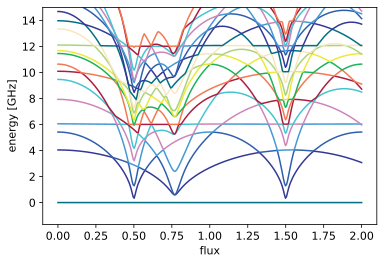

In [17]:
splot.dressed_spectrum(sweep);